In [18]:
import stim

from faulttools import PauliString

# c = stim.Circuit.generated(
#     "surface_code:rotated_memory_z",
#     rounds=1,
#     distance=3,
#     after_clifford_depolarization=0.001,
#     after_reset_flip_probability=0.001,
#     before_measure_flip_probability=0.001,
#     before_round_data_depolarization=0.001,
# )
# c = c.flattened()

c = stim.Circuit("""
R 1 3 5 8 10 12 15 17 19
X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
X_ERROR(0.001) 2 9 11 13 14 16 18 25
DEPOLARIZE1(0.001) 1 3 5 8 10 12 15 17 19
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE1(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE1(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE1(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE1(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
X_ERROR(0.001) 2 9 11 13 14 16 18 25
MR 2 9 11 13 14 16 18 25
X_ERROR(0.001) 2 9 11 13 14 16 18 25
DETECTOR(0, 4, 0) rec[-4]
DETECTOR(2, 2, 0) rec[-7]
DETECTOR(4, 4, 0) rec[-2]
DETECTOR(6, 2, 0) rec[-5]
X_ERROR(0.001) 1 3 5 8 10 12 15 17 19
M 1 3 5 8 10 12 15 17 19
DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
""")

In [19]:
import pyzx as zx

from faulttools.diagram.conversion import to_pyzx, from_stim

d, nm = from_stim(c)
print(len(nm.atomic_weights()))

zx_diagram, node_map = to_pyzx(d, with_mapping=True)
reverse_node_map = { pyzx_node: n for n, pyzx_node in node_map.items() }
zx.draw(zx_diagram, labels=True)

229


In [20]:
import sinter
from faulttools import export_to_stim_dem
from faulttools.glue import wrap_dem_as_sinter_task

stim_dem = c.detector_error_model()
dem = export_to_stim_dem(nm, logicals=[PauliString({
    d.edge_indices_from_endpoints(reverse_node_map[102], reverse_node_map[128])[0]: "X",
    d.edge_indices_from_endpoints(reverse_node_map[99], reverse_node_map[130])[0]: "X",
    d.edge_indices_from_endpoints(reverse_node_map[106], reverse_node_map[132])[0]: "X",
})])

collected_stats = sinter.collect(
    num_workers=16,
    tasks=[
        sinter.Task(circuit=c,detector_error_model=stim_dem, json_metadata={"p": 0.001, "name": "stim original"}),
        wrap_dem_as_sinter_task(dem, json_metadata={"p": 0.001, "name": "replica"}),
    ],
    max_shots=1000_000_000,
    decoders=["vacuous"],
    print_progress=True,
)

Starting 16 workers...
2 tasks left:
  workers decoder   eta shots_left errors_seen json_metadata             
        8 vacuous 1363m  999999999           0 p=0.001,name=stim original
        8 vacuous     ? 1000000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m  992575864      102963 p=0.001,name=stim original
        8 vacuous   ? 1000000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m  988480888      159808 p=0.001,name=stim original
        8 vacuous   ? 1000000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left errors_seen json_metadata             
        8 vacuous <1m  983392632      230322 p=0.001,name=stim original
        8 vacuous   ? 1000000000           0 p=0.001,name=replica      
2 tasks left:
  workers decoder eta shots_left erro

Stim: 0.013812393 error rate
NEW: 0.013818952 error rate


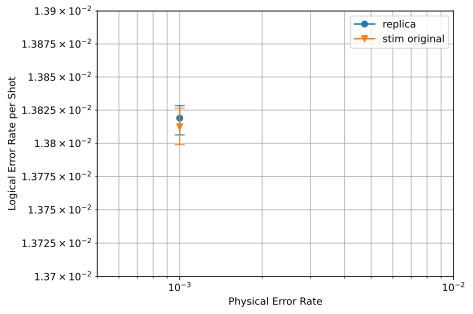

In [25]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata["p"],
    group_func=lambda stats: stats.json_metadata["name"],
)
print(f"Stim: {collected_stats[0].errors / collected_stats[0].shots} error rate")
print(f"NEW: {collected_stats[1].errors / collected_stats[1].shots} error rate")
ax.set_ylim(0.0137, 0.0139)
ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [22]:
print(stim_dem)

error(0.001665333333333335938) D0
error(0.001665333333333335938) D0 D1
error(0.0033251199964444496) D0 D4
error(0.001665333333333335938) D1 D2
error(0.0006666666666666692465) D1 D4
error(0.004648703365556151879) D1 D5
error(0.005309171761068747636) D1 L0
error(0.004648703365556152746) D2
error(0.002993339849481488867) D2 D3
error(0.0006666666666666692465) D2 D4
error(0.001997334518518526208) D2 D5
error(0.004648703365556151879) D2 D6
error(0.0006666666666666692465) D3 D5
error(0.0006666666666666692465) D3 D6
error(0.0033251199964444496) D3 D7
error(0.002329779555555560461) D3 L0
error(0.002329779555555560894) D4
error(0.0029933398494814893) D4 D5
error(0.001665333333333335938) D5 D6
error(0.004648703365556152746) D5 L0
error(0.005309171761068746768) D6
error(0.001665333333333335938) D6 D7
error(0.001665333333333335938) D7 L0
detector(0, 4, 0) D0
detector(2, 2, 0) D1
detector(4, 4, 0) D2
detector(6, 2, 0) D3
detector(0, 4, 1) D4
detector(2, 2, 1) D5
detector(4, 4, 1) D6
detector(6, 2, 1

In [23]:
print(dem)

error(0.001000000000000000021) L0 D18 D19 D20 D21 D22 D23
error(0.000333444518580305882) L0 D18 D19 D20 D21 D22 D23
error(0.000333444518580305882) L0 D18 D19 D20 D21 D22 D23
error(0.001000000000000000021) D20
error(0.000333444518580305882) D20
error(0.000333444518580305882) D20
error(0.001000000000000000021) D18
error(0.000333444518580305882) D18
error(0.000333444518580305882) D18
error(0.001000000000000000021) D22
error(0.000333444518580305882) D22
error(0.000333444518580305882) D22
error(0.001000000000000000021) D24
error(0.001000000000000000021) D19 D20 D22
error(0.000333444518580305882) D19 D20 D22
error(0.000333444518580305882) D19 D20 D22
error(0.001000000000000000021) D19 D20 D21 D22
error(0.001000000000000000021) D20
error(0.000333444518580305882) D20
error(0.000333444518580305882) D20
error(0.001000000000000000021) D25
error(0.000333444518580305882) L0 D18 D19 D20 D21 D22 D23
error(0.000333444518580305882) L0 D18 D19 D20 D21 D22 D23
error(0.001000000000000000021) L0 D18 D19 D2